In [1]:
import shutil

# importing the sys module
import sys        
 
# appending the directory of mod.py
# in the sys.path list
sys.path.append('../')   

import json
import os
import random
from collections import defaultdict

import torch
from PIL import Image
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.optim import Adam
import numpy as np
from sklearn.model_selection import train_test_split

from datetime import datetime

from Common.Optimizers.RangerLars import RangerLars
from Common.Schedulers.GradualWarmupScheduler import GradualWarmupScheduler

import diff_pipeline4__config as cfg
#diff_pipeline4__dataset_simple
from diff_pipeline4__dataset_copy import DiffPipeline4SameUniformDiffDataset, DiffPipeline4MixedUniformDiffDataset, DiffPipeline4MimicDiffDataset, get_error_constrained_dataset
from Common.Datasets.Morph2.data_parser import DataParser
from diff_pipeline4__train import train_diff_cls_model_iter


from diff_pipeline4__model import DiffPipeline4Model, DiffPipeline4DeepModel, AgeDiffModel, DiffModelConfigType

from tqdm import tqdm

from sklearn import utils



#####################################################
#           Preparations
#####################################################

torch.manual_seed(cfg.RANDOM_SEED)
np.random.seed(cfg.RANDOM_SEED)
random.seed(cfg.RANDOM_SEED)

# if cfg.USE_GPU:
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# else:
device = torch.device("cpu")

print(device)

torch.cuda.empty_cache()

#####################################################
#           Data Loading
#####################################################

with open("im2age_map_test.json", 'r') as im2age_map_test_f:
    im2age_map_test = json.load(im2age_map_test_f)

# Load data
data_parser = DataParser('../Common/Datasets/Morph2/aligned_data/aligned_dataset_with_metadata_uint8.hdf5', small_data=cfg.SMALL_DATA)
data_parser.initialize_data()


x_train, y_train, x_test, y_test = data_parser.x_train,	data_parser.y_train, data_parser.x_test, data_parser.y_test,
if cfg.RANDOM_SPLIT:
    all_images = np.concatenate((x_train, x_test), axis=0)
    all_labels = np.concatenate((y_train, y_test), axis=0)

    x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=cfg.TEST_SIZE_FOR_RS, random_state=cfg.RANDOM_SEED)


cpu


In [2]:
import matplotlib.pyplot as plt

In [3]:
face2emb_arr_trn_r = np.load('face2emb_arr_trn.npy', allow_pickle=True)
#     import pdb
#     pdb.set_trace()
#face2emb_arr_trn_r = face2emb_arr_trn_r.item()

face2emb_arr_vld_r = np.load('face2emb_arr_vld.npy', allow_pickle=True)
#face2emb_arr_vld_r = face2emb_arr_vld_r.item()

# shuffle basic aligned test
# x_test_shuffled
# y_test_shuffled


transf = transforms.Compose([
        transforms.RandomResizedCrop(224, (0.9, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.1,
            hue=0.1
        )], p=0.5),
        transforms.RandomApply([transforms.RandomAffine(
            degrees=10,
            translate=(0.1, 0.1),
            scale=(0.9, 1.1),
            shear=5,
            resample=Image.BICUBIC
        )], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.5)
    ])

# transf = transforms.Compose([
#         transforms.Resize(224), # just for testing
# #          transforms.RandomResizedCrop(224, (0.9, 1.0)),
# #          transforms.RandomHorizontalFlip(),
#         transforms.RandomApply([transforms.ColorJitter(
#             brightness=0.1,
#             contrast=0.1,
#             saturation=0.1,
#             hue=0.1
#         )], p=0.5),
# #         transforms.RandomApply([transforms.RandomAffine(
# #             degrees=10,
# #             translate=(0.1, 0.1),
# #             scale=(0.9, 1.1),
# #             shear=5,
# #             resample=Image.BICUBIC
# #         )], p=0.5),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# #        transforms.RandomErasing(p=0.5)
# ])

train_ds = DiffPipeline4SameUniformDiffDataset(
    data_set_images=x_train,
    data_set_metadata=y_train,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_radius=cfg.AGE_RADIUS,
    age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
    age_diff_learn_radius_hi=3,#cfg.AGE_DIFF_LEARN_RADIUS_HI,
    embs=face2emb_arr_trn_r,
    #num_references=cfg.NUM_OF_REFS
)

print("Training (q trn, r trn) set size: " + str(len(train_ds)))

test_qtst_rtst_ds = DiffPipeline4SameUniformDiffDataset(
    data_set_images=x_test,
    data_set_metadata=y_test,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_radius=cfg.AGE_RADIUS,
    age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
    age_diff_learn_radius_hi=3,#cfg.AGE_DIFF_LEARN_RADIUS_HI,
    embs=face2emb_arr_vld_r,
    #num_references=cfg.NUM_OF_REFS
)

print("Testing (q tst, r tst) set size: " + str(len(test_qtst_rtst_ds)))

test_qtst_rtrn_ds = DiffPipeline4MixedUniformDiffDataset(
    batrn_set_images=x_train,
    batrn_set_metadata=y_train,
    batst_set_images=x_test,
    batst_set_metadata=y_test,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_radius=cfg.AGE_RADIUS,
    age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
    age_diff_learn_radius_hi=3,#cfg.AGE_DIFF_LEARN_RADIUS_HI,
    embs_trn=face2emb_arr_trn_r,
    embs_vld=face2emb_arr_vld_r,
    #num_references=cfg.NUM_OF_REFS
)

print("Testing (q tst, r trn) set size: " + str(len(test_qtst_rtrn_ds)))

x_test_filtered, y_test_filtered, batst_set_filtered_indexes = get_error_constrained_dataset(orig_dataset_images=x_test, 
                                                                                                orig_dataset_metadata=y_test,
                                                                                                age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
                                                                                                age_diff_learn_radius_hi=3,#cfg.AGE_DIFF_LEARN_RADIUS_HI,
                                                                                                im2age_map_batst=im2age_map_test)

# apref = Age Predict Reference (dataset is based on (q,r) pairs where r's age is what AgePredict model returns on q)
test_apref_ds = DiffPipeline4MimicDiffDataset(
    batrn_set_images=x_train,
    batrn_set_metadata=y_train,
    batst_set_images=x_test_filtered,
    batst_set_metadata=y_test_filtered,
    batst_set_indexes=batst_set_filtered_indexes,
    im2age_map_batst=im2age_map_test,
    min_age=cfg.MIN_AGE,
    age_interval=cfg.AGE_INTERVAL,
    max_age=cfg.MAX_AGE,
    transform=transf,
    copies=1, 
    age_radius=cfg.AGE_RADIUS,
    embs_trn=face2emb_arr_trn_r,
    embs_vld=face2emb_arr_vld_r,
    #num_references=cfg.NUM_OF_REFS
)

print("Testing (q tst where AgePredict(q)  {age_diff_learn_radius_lo} <= error <= {age_diff_learn_radius_hi}, r trn where age(r)=AgePredict(q)) set size: ".format(age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO, age_diff_learn_radius_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI) + str(len(test_apref_ds)))

x_test_all, y_test_all, batst_set_all_indexes = get_error_constrained_dataset(orig_dataset_images=x_test, 
                                                                                                orig_dataset_metadata=y_test,
                                                                                                age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO,
                                                                                                age_diff_learn_radius_hi=3,#35,#cfg.AGE_RADIUS,
                                                                                                im2age_map_batst=im2age_map_test)


# apref = Age Predict Reference (dataset is based on (q,r) pairs where r's age is what AgePredict model returns on q)
# test_apref_all_ds = DiffPipeline4MimicDiffDataset(
# 	batrn_set_images=x_train,
# 	batrn_set_metadata=y_train,
#     batst_set_images=x_test_all,
#     batst_set_metadata=y_test_all,
#     batst_set_indexes=batst_set_all_indexes,
#     im2age_map_batst=im2age_map_test,
# 	min_age=cfg.MIN_AGE,
# 	age_interval=cfg.AGE_INTERVAL,
#     max_age=cfg.MAX_AGE,
# 	transform=transf,
#     copies=1, 
#     age_radius=cfg.AGE_RADIUS,
#     embs_trn=face2emb_arr_trn_r,
#     embs_vld=face2emb_arr_vld_r#,
#     #num_references=cfg.NUM_OF_REFS
# )

# print("Testing (q tst where AgePredict(q)  {age_diff_learn_radius_lo} <= error <= {age_diff_learn_radius_hi}, r trn where age(r)=AgePredict(q)) set size: ".format(age_diff_learn_radius_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO, age_diff_learn_radius_hi=35) + str(len(test_apref_all_ds))) #cfg.AGE_RADIUS





image_datasets = {
    'train': train_ds,
    'val_qtst_rtst': test_qtst_rtst_ds,
    'val_qtst_rtrn': test_qtst_rtrn_ds,
    'val_apref_ds': test_apref_ds,
    #'val_apref_all_ds': test_apref_all_ds
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val_qtst_rtst', 'val_qtst_rtrn', 'val_apref_ds']}#, 'val_apref_all_ds']}

data_loaders = {
    'train': DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=True, drop_last=True),
    'val_qtst_rtst': DataLoader(test_qtst_rtst_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True),
    'val_qtst_rtrn': DataLoader(test_qtst_rtrn_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True),
    'val_apref_ds': DataLoader(test_apref_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True),
    #'val_apref_all_ds' : DataLoader(test_apref_all_ds, batch_size=cfg.BATCH_SIZE, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=True)
}

C:\Users\proj\.conda\envs\my_thesis_py38\lib\site-packages\torchvision\transforms\transforms.py:1361: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


Training (q trn, r trn) set size: 44285
Testing (q tst, r tst) set size: 10606
Testing (q tst, r trn) set size: 10606
Testing (q tst where AgePredict(q)  0 <= error <= 35, r trn where age(r)=AgePredict(q)) set size: 7012


In [4]:
from tqdm import tqdm

total_sample = np.array([])
for i, batch in enumerate(tqdm(data_loaders['train'])):
    total_sample = np.concatenate((total_sample, batch['age_diff'].numpy()))
#     if i % 5 == 0:
#         print(np.histogram(total_sample, bins=[-3,-2,-1,0,1,2,3]))

100%|██████████████████████████████████████████████████████████████████████████████| 1383/1383 [27:54<00:00,  1.21s/it]


(array([6619., 6647.,    0., 6454.,    0., 6637., 6299.,    0., 5953.,
        5647.]),
 array([-3. , -2.4, -1.8, -1.2, -0.6,  0. ,  0.6,  1.2,  1.8,  2.4,  3. ]),
 <BarContainer object of 10 artists>)

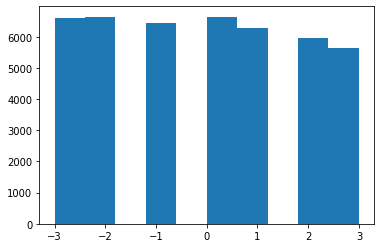

In [5]:
plt.hist(total_sample)